# **AN2DL Challenge 2 - Image Classification**


In [ ]:
# Enviroment
isColab = False
colab_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
colab_dataset_dir = f"{colab_dir}/dataset"

isKaggle = False
isWsl = True

# Set seed for reproducibility
SEED = 42

## **Loading Enviroment**

In [ ]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive
    drive.mount("/gdrive")
    current_dir = colab_dir
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

Esecuzione su WSL. Directory corrente impostata a: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Changed directory to: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2


## **Import Libraries**

In [ ]:
# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
%pip install torchview
from torchview import draw_graph


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.")

os.makedirs("models", exist_ok=True)
    
%pip install lion-pytorch    

%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.9.1+cu130
Device: cuda


## **Dataset Downloading**


In [4]:
dataset_dir = os.path.join(current_dir, "dataset")

if isColab:
    # Clean up path for Python usage (remove shell escapes)
    clean_current_dir = current_dir.replace('\\ ', ' ')
    drive_dataset_dir = os.path.join(clean_current_dir, "dataset")
    local_dataset_dir = "/content/dataset"
    
    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")
    
    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

elif isKaggle:
    # Nothing to do, dataset is already available in Kaggle environment
    print("Running on Kaggle. Dataset is assumed to be already available.")
    print(f"Dataset directory: {dataset_dir}")
else:
    # Check if dataset is already downloaded
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir, exist_ok=True)
        
    if not os.listdir(dataset_dir):
        print("Downloading dataset from Kaggle in local environment...")
        os.chdir(dataset_dir)
        !kaggle competitions download -c an2dl2526c2
        zip_file = "an2dl2526c2.zip"
        shutil.unpack_archive(zip_file, extract_dir=".")
        os.remove(zip_file)
        os.chdir(current_dir)
    else:
        print("Dataset already present in local environment. Skipping download.")

# Define absolute paths
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")
        
print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Dataset already present in local environment. Skipping download.
Dataset directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset
Train set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_data
Test set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data
Label file: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_labels.csv


## ⏳ **Data Loading**


In [5]:
# Loader parameters
APPLY_MASK = False
BATCH_SIZE = 64
LOADER_SHUFFLE = False

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

LABEL_MAP = {"Luminal A": 0, "Luminal B": 1, "HER2(+)": 2, "Triple negative": 3}
IMG_RESIZE = (224, 224)
input_shape = (3, *IMG_RESIZE)
num_classes = len(LABEL_MAP)

TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2
TRAIN_SET_SIZE = 1.0 - TEST_SET_SIZE - VAL_SET_SIZE

In [6]:
train_augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ]
)

# No augmentation for validation/test
transform = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

### **Definitions**


In [7]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import numpy as np


class IronGutsDataset(Dataset):
    """
    Custom Dataset for the Iron-Guts (Breast Cancer) competition.

    Features:
    1. Lazy Loading: Reads images from disk on-the-fly to save RAM.
    2. Integrity Checks: Ensures every image has a corresponding mask.
    3. Mask Gating: Uses the binary mask to suppress background noise (setting it to pure black).
    """

    def __init__(
        self,
        root_dir,
        data,
        transform=None,
        augmentation=None,
        target_transform=None,
        apply_mask=False,
    ):
        """
        Args:
            root_dir (str): Directory with all images and masks.
            data (str or pd.DataFrame): Path to the CSV file with annotations or the DataFrame itself.
            transform (callable, optional): Transform to be applied on the image (e.g., Resize, ToTensor).
            augmentation (callable, optional): Augmentation transforms to be applied on the image.
            target_transform (callable, optional): Transform to be applied on the label.
            apply_mask (bool, optional): Whether to apply mask gating. Default: True.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation
        self.target_transform = target_transform
        self.apply_mask = apply_mask

        # Load the CSV
        if isinstance(data, str):
            self.annotations = pd.read_csv(data)
            print(f"Loaded {len(self.annotations)} annotations from {data}")
        elif isinstance(data, pd.DataFrame):
            self.annotations = data
            print(f"Loaded {len(self.annotations)} annotations from DataFrame")
        else:
            raise ValueError("data must be a file path or a pandas DataFrame")

        # Define class mapping based on the biological subtypes
        # ['Triple negative' 'Luminal A' 'Luminal B' 'HER2(+)']
        self.label_map = LABEL_MAP

        # Validation: Check that dataset is not empty
        if len(self.annotations) == 0:
            raise RuntimeError("Dataset CSV is empty.")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 1. Parse File Paths
        # The CSV contains 'sample_index' like 'img_5', we need to append extensions.
        img_id = self.annotations.iloc[idx]["sample_index"]
        img_name = f"{img_id}"
        mask_name = f"{img_id.replace('img_', 'mask_')}"

        img_path = os.path.join(self.root_dir, img_name)
        mask_path = os.path.join(self.root_dir, mask_name)

        # 2. Load Data (Lazy Operation)
        # We convert image to RGB (3 channels) and mask to L (grayscale/binary)
        try:
            image = Image.open(img_path).convert("RGB")
            if self.apply_mask:
                mask = Image.open(mask_path).convert("L")
        except FileNotFoundError:
            raise FileNotFoundError(f"Missing file pair: {img_name} or {mask_name}")

        # 3. Apply Mask Gating (Background Suppression) - only if flag is enabled
        if self.apply_mask:
            # Tissue is signal, background is noise.
            # We multiply the image by the mask to force background to absolute 0.
            image_np = np.array(image)
            mask_np = np.array(mask)

            # Ensure mask is binary (0 or 1) for broadcasting
            # Any pixel > 0 in the mask is considered tissue
            binary_mask = (mask_np > 0).astype(np.uint8)

            # Expand dimensions of mask to match image (H, W, 1) for broadcasting
            binary_mask = np.expand_dims(binary_mask, axis=-1)

            # Apply gating: Image * Mask
            masked_image_np = image_np * binary_mask

            # Convert back to PIL for standard PyTorch transforms
            masked_image = Image.fromarray(masked_image_np)
        else:
            masked_image = image

        # 4. Apply Transforms (e.g., Resize, ToTensor, Normalize)
        if self.transform:
            masked_image = self.transform(masked_image)

        if self.augmentation:
            masked_image = self.augmentation(masked_image)

        # 5. Handle Labels
        label_str = self.annotations.iloc[idx]["label"]
        label = self.label_map[str(label_str)]

        if self.target_transform:
            label = self.target_transform(label)

        return masked_image, label

In [8]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, cpu_cores - 2)

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers if isColab or isKaggle or isWsl else 0,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4 if isColab or isKaggle or isWsl else None,
        persistent_workers=(isColab or isKaggle or isWsl) and num_workers > 0,
    )

In [9]:
SAMPLES_TO_IGNORE = [
    "img_0102.png", "img_0104.png", "img_0108.png", "img_0109.png", "img_0112.png",
    "img_0130.png", "img_0147.png", "img_0152.png", "img_0153.png", "img_0168.png",
    "img_0173.png", "img_0176.png", "img_0182.png", "img_0189.png", "img_0193.png",
    "img_0203.png", "img_0213.png", "img_0218.png", "img_0223.png", "img_0228.png",
    "img_0232.png", "img_0237.png", "img_0239.png", "img_0249.png", "img_0250.png",
    "img_0256.png", "img_0264.png", "img_0269.png", "img_0270.png", "img_0271.png",
    "img_0276.png", "img_0277.png", "img_0282.png", "img_0290.png", "img_0291.png",
    "img_0304.png", "img_0308.png", "img_0318.png", "img_0322.png", "img_0323.png",
    "img_0328.png", "img_0336.png", "img_0342.png", "img_0348.png", "img_0357.png",
    "img_0365.png", "img_0368.png", "img_0369.png", "img_0370.png", "img_0379.png",
    "img_0384.png", "img_0386.png", "img_0390.png", "img_0391.png", "img_0394.png",
    "img_0404.png", "img_0406.png", "img_0411.png", "img_0413.png", "img_0418.png",
    "img_0422.png", "img_0426.png", "img_0428.png", "img_0430.png", "img_0436.png",
    "img_0438.png", "img_0442.png", "img_0446.png", "img_0447.png", "img_0448.png",
    "img_0451.png", "img_0454.png", "img_0455.png", "img_0456.png", "img_0469.png",
    "img_0471.png", "img_0478.png", "img_0480.png", "img_0481.png", "img_0487.png",
    "img_0489.png", "img_0492.png", "img_0493.png", "img_0495.png", "img_0503.png",
    "img_0505.png", "img_0509.png", "img_0511.png", "img_0512.png", "img_0514.png",
    "img_0516.png", "img_0518.png", "img_0520.png", "img_0521.png", "img_0526.png",
    "img_0527.png", "img_0529.png", "img_0536.png", "img_0554.png", "img_0555.png",
    "img_0559.png", "img_0572.png", "img_0574.png", "img_0586.png", "img_0589.png",
    "img_0592.png", "img_0594.png", "img_0597.png", "img_0600.png", "img_0606.png",
    "img_0608.png", "img_0612.png", "img_0629.png", "img_0631.png", "img_0648.png",
    "img_0650.png", "img_0652.png", "img_0653.png", "img_0655.png", "img_0665.png",
    "img_0673.png", "img_0681.png", "img_0687.png", "img_0703.png", "img_0714.png",
    "img_0731.png", "img_0733.png", "img_0735.png", "img_0748.png", "img_0753.png",
    "img_0755.png", "img_0758.png", "img_0767.png", "img_0771.png", "img_0796.png",
    "img_0800.png", "img_0804.png", "img_0813.png", "img_0817.png", "img_0819.png",
    "img_0822.png", "img_0825.png", "img_0826.png", "img_0829.png", "img_0832.png",
    "img_0866.png", "img_0868.png", "img_0892.png", "img_0893.png", "img_0898.png",
    "img_0903.png", "img_0906.png", "img_0907.png", "img_0910.png", "img_0913.png",
    "img_0918.png", "img_0919.png", "img_0924.png", "img_0930.png", "img_0935.png",
    "img_0936.png", "img_0937.png", "img_0941.png", "img_0944.png", "img_0958.png",
    "img_0960.png", "img_0963.png", "img_0973.png", "img_0982.png", "img_0991.png",
    "img_0992.png", "img_0999.png", "img_1004.png", "img_1005.png", "img_1006.png",
    "img_1009.png", "img_1011.png", "img_1015.png", "img_1017.png", "img_1021.png",
    "img_1023.png", "img_1035.png", "img_1037.png", "img_1039.png", "img_1041.png",
    "img_1046.png", "img_1062.png", "img_1086.png", "img_1108.png", "img_1109.png",
    "img_1114.png", "img_1124.png", "img_1125.png", "img_1133.png", "img_1145.png",
    "img_1146.png", "img_1150.png", "img_1156.png", "img_1177.png", "img_1184.png",
    "img_1186.png", "img_1202.png", "img_1206.png", "img_1212.png", "img_1217.png",
    "img_1218.png", "img_1220.png", "img_1223.png", "img_1229.png", "img_1232.png",
    "img_1236.png", "img_1241.png", "img_1245.png", "img_1258.png", "img_1261.png",
    "img_1263.png", "img_1267.png", "img_1271.png", "img_1274.png", "img_1277.png",
    "img_1280.png", "img_1281.png", "img_1298.png", "img_1300.png", "img_1312.png",
    "img_1317.png", "img_1320.png", "img_1326.png", "img_1327.png", "img_1329.png",
    "img_1332.png", "img_1334.png", "img_1335.png", "img_1338.png", "img_1340.png",
    "img_1360.png", "img_1361.png", "img_1362.png", "img_1367.png", "img_1369.png",
    "img_1375.png", "img_1376.png", "img_1377.png", "img_1381.png", "img_1385.png",
    "img_1388.png", "img_1389.png", "img_1392.png", "img_0846.png","img_1192.png",
]

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Load the full dataframe
full_df = pd.read_csv(label_file)

# Remove cursed images
full_df = full_df[~full_df['sample_index'].isin(SAMPLES_TO_IGNORE)].reset_index(drop=True)

train_df, temp_df = train_test_split(
    full_df,
    test_size=(TEST_SET_SIZE + VAL_SET_SIZE),
    stratify=full_df["label"],
    random_state=SEED,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=VAL_SET_SIZE,
    stratify=temp_df["label"],
    random_state=SEED,
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Create Datasets
train_set = IronGutsDataset(
    root_dir=train_set_dir,
    data=train_df,
    transform=transform,
    augmentation=train_augmentation,
    apply_mask=APPLY_MASK,
)

val_set = IronGutsDataset(
    root_dir=train_set_dir,
    data=val_df,
    transform=transform,
    apply_mask=APPLY_MASK,
)

test_set = IronGutsDataset(
    root_dir=train_set_dir,
    data=test_df,
    transform=transform,
    apply_mask=APPLY_MASK,
)

# Create DataLoaders
train_loader = make_loader(
    ds=train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)

val_loader = make_loader(
    ds=val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

test_loader = make_loader(
    ds=test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

# Check a batch
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Train set size: 697
Validation set size: 372
Test set size: 93
Loaded 697 annotations from DataFrame
Loaded 372 annotations from DataFrame
Loaded 93 annotations from DataFrame
Batch of images shape: torch.Size([64, 3, 224, 224])
Batch of labels shape: torch.Size([64])


## 🧮 **Network Parameters**


In [11]:
# Training parameters
LEARNING_RATE = 1e-3
EPOCHS = 200
PATIENCE = 20

# Regularization
DROPOUT_RATE = 0.3
LABEL_SMOOTHING = 0.05

# Set up loss function
# Manage Class imbalance
class_counts = full_df["label"].value_counts().sort_index()
total_samples = len(full_df)
num_classes = len(class_counts)

class_weights = total_samples / (num_classes * class_counts)
# Convert to tensor for PyTorch usage later
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

## 🧠 **Training Functions**


In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(
            device_type=device.type, enabled=(device.type == "cuda")
        ):
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets), np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc

In [13]:
def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(
                device_type=device.type, enabled=(device.type == "cuda")
            ):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(
        np.concatenate(all_targets), np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_accuracy

In [14]:
def fit(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    optimizer,
    scaler,
    device,
    patience=0,
    evaluation_metric="val_acc",
    mode="max",
    restore_best_weights=True,
    writer=None,
    verbose=1,
    experiment_name="",
):
    """Train the neural network model."""

    training_history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float("-inf") if mode == "max" else float("inf")
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        training_history["train_loss"].append(train_loss)
        training_history["val_loss"].append(val_loss)
        training_history["train_acc"].append(train_acc)
        training_history["val_acc"].append(val_acc)

        if writer is not None:
            writer.add_scalar("Loss/Training", train_loss, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("Accuracy/Training", train_acc, epoch)
            writer.add_scalar("Accuracy/Validation", val_acc, epoch)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(
                    f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                    f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}"
                )

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (
                (current_metric > best_metric)
                if mode == "max"
                else (current_metric < best_metric)
            )

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(
                    model.state_dict(), "models/" + experiment_name + "_model.pt"
                )
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(
            f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}"
        )

    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    if writer is not None:
        writer.close()

    return model, training_history

## 🛠️ **Train EfficientNetB0 from Scratch**


In [15]:
class EfficientNetB0FromScratch(nn.Module):
    """EfficientNet-B0 trained from scratch (Random weights)."""

    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()

        # Load architecture with NO pretrained weights
        self.backbone = torchvision.models.efficientnet_b0(weights=None)

        # Re-build classifier head
        # EfficientNet classifier is a Sequential; the Linear layer is the last one [-1]
        in_features = self.backbone.classifier[-1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

In [16]:
# Initialize model
scratch_model = EfficientNetB0FromScratch(len(LABEL_MAP), DROPOUT_RATE).to(device)

# Visualize structure
summary(scratch_model, input_size=input_shape)
try:
    from torchview import draw_graph

    model_graph = draw_graph(
        scratch_model,
        input_size=(BATCH_SIZE,) + input_shape,
        expand_nested=True,
        depth=6,
    )
    model_graph.visual_graph
except Exception as e:
    print(f"Could not visualize model graph: {e}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [17]:
# Setup Training
experiment_name = "from_scratch"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)
optimizer = torch.optim.Adam(
    scratch_model.parameters(),
    lr=LEARNING_RATE,
)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

In [18]:
%%time

# Train the model from scratch
scratch_model, history = fit(
    model=scratch_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    patience=PATIENCE,
    experiment_name=experiment_name,
)

Training 200 epochs...


Epoch   1/200 | Train: Loss=1.5731, Acc=0.2884 | Val: Loss=1.3893, Acc=0.3495
Epoch   5/200 | Train: Loss=1.4563, Acc=0.3214 | Val: Loss=1.4234, Acc=0.3199
Epoch  10/200 | Train: Loss=1.4034, Acc=0.3386 | Val: Loss=9.4679, Acc=0.1667
Epoch  15/200 | Train: Loss=1.4060, Acc=0.3429 | Val: Loss=2.6728, Acc=0.1640
Epoch  20/200 | Train: Loss=1.3791, Acc=0.3357 | Val: Loss=7.6117, Acc=0.1425
Epoch  25/200 | Train: Loss=1.3754, Acc=0.3314 | Val: Loss=1.6876, Acc=0.1532
Early stopping triggered after 27 epochs.
Best model restored from epoch 7 with val_acc 0.3522
CPU times: user 2min 54s, sys: 21.3 s, total: 3min 16s
Wall time: 15min 9s


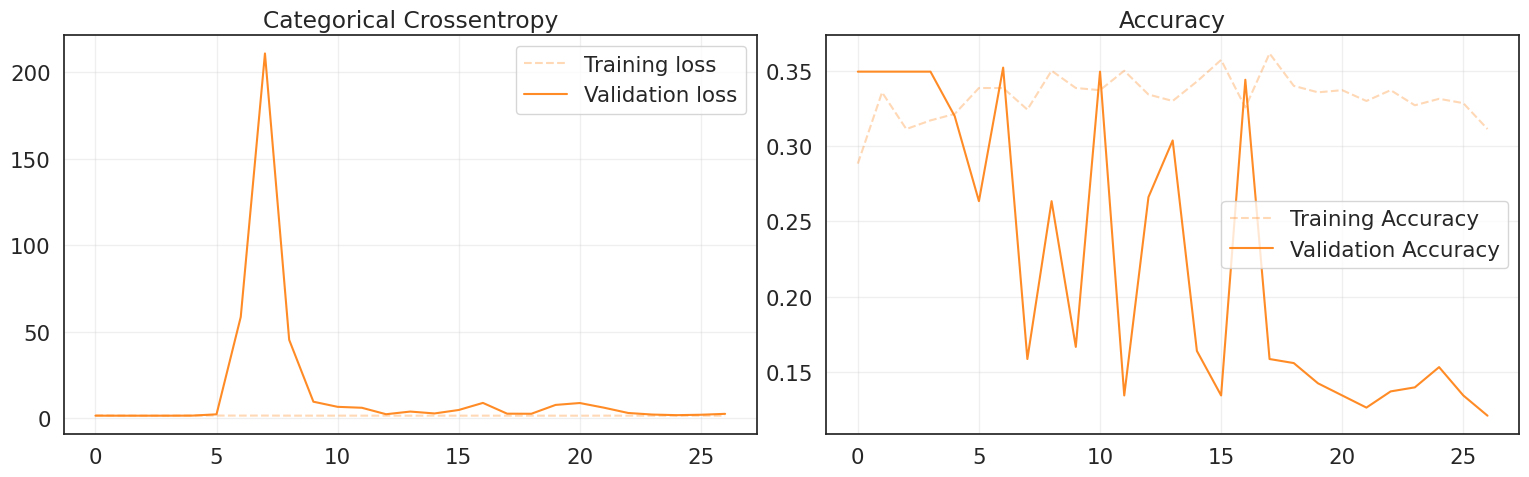

In [19]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(
    history["train_loss"],
    label="Training loss",
    alpha=0.3,
    color="#ff7f0e",
    linestyle="--",
)
ax1.plot(history["val_loss"], label="Validation loss", alpha=0.9, color="#ff7f0e")
ax1.set_title("Categorical Crossentropy")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(
    history["train_acc"],
    label="Training Accuracy",
    alpha=0.3,
    color="#ff7f0e",
    linestyle="--",
)
ax2.plot(history["val_acc"], label="Validation Accuracy", alpha=0.9, color="#ff7f0e")
ax2.set_title("Accuracy")
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()